CSE 546: Assignment 1

In [1]:
!pip install gym

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [2]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, n = 3, is_stochastic = False):
        self.observation_space = spaces.Discrete(n ** 2)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 2 * n + 1
        self.is_stochastic = is_stochastic
        self.n = n

        # defining stochastic environment such that ∑P_i = 1
        if self.is_stochastic:
          self.transition_prob = []
          for i in range(n):
            x = []
            for j in range(n):
              y = []
              for action in range(self.action_space.n):
                z = [.1] * self.action_space.n
                z[action] = .7
                y.append(z)
              x.append(y)
            self.transition_prob.append(x)

        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.n - 1, self.n - 1]
        self.monster_pos = [self.n // 2, self.n // 2]
        self.update_state()
        observation = self.agent_pos
        return observation
    
    def update_state(self):
      self.state = np.zeros((self.n, self.n))
      self.state[tuple(self.goal_pos)] = 0.5
      self.state[tuple(self.monster_pos)] = 0.25
      self.state[tuple(self.agent_pos)] = 1

    def get_action(self, x, y, action):
      return np.random.choice(self.action_space.n, p = self.transition_prob[x][y][action])

    def step(self, action):
        if self.is_stochastic:
          action = self.get_action(self.agent_pos[0], self.agent_pos[1], action)

        # top-left: (0, 0)
        if action == 0: #down
          self.agent_pos[0] += 1
        if action == 1: #up
          self.agent_pos[0] -= 1
        if action == 2: #right
          self.agent_pos[1] += 1
        if action == 3: #left
          self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.n - 1)
        self.update_state()
        observation = self.agent_pos
        
        reward = 0
        goal_reached = (self.agent_pos == self.goal_pos).all()
        if goal_reached:
          reward = 10

        if (self.agent_pos == self.monster_pos).all():
          reward = -10
        
        self.timestep += 1
        done = True if (self.timestep >= self.max_timesteps) or goal_reached else False
        info = {}
        
        return observation, reward, done, info
        
    def render(self):
        plt.imshow(self.state)

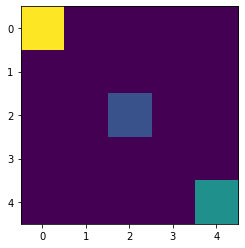

In [3]:
env = GridEnvironment(5)
obs = env.reset()
env.render()

Reward: 10


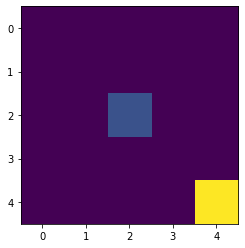

In [39]:
action = np.random.randint(env.action_space.n)
observation, reward, done, info = env.step(action)
env.render()
print('Reward:', reward)